# Module 8 Group 25 Transfer learning model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from numpy import expand_dims
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings("ignore")


##Loading images from a directory

In [ ]:
imgdir = '/content/drive/MyDrive/chest_xray/'
data_gen = ImageDataGenerator(rescale=1.0/255)
img_size = 128

In [ ]:
# Read the images in the training set
train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=8,
        class_mode='binary',
        classes=['NORMAL', 'PNEUMONIA'],
        seed=12345,
        shuffle=True)

Found 5216 images belonging to 2 classes.


In [ ]:
# Read the images in the validation set
validation_generator = data_gen.flow_from_directory(
        imgdir + '/val',
        target_size=(img_size, img_size),
        batch_size=2,
        class_mode='binary',
        classes=['NORMAL', 'PNEUMONIA'],
        seed=12345,
        shuffle=True)

Found 16 images belonging to 2 classes.


In [ ]:
# Read the images in the test set
test_generator = data_gen.flow_from_directory(
        imgdir + '/test',
        target_size=(img_size, img_size),
        batch_size=1,
        class_mode='binary',
        classes=['NORMAL', 'PNEUMONIA'],
        seed=12345,
        shuffle=True)

Found 624 images belonging to 2 classes.


In [ ]:
Xbatch, Ybatch = train_generator.next()
Xbatch.shape

(8, 128, 128, 3)

In [ ]:
Ybatch[1]

1.0

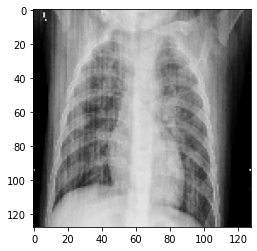

In [ ]:
plt.imshow(Xbatch[4], cmap = 'gray')

##Data Augmentation

In [ ]:
Image_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        samplewise_center=True,
        samplewise_std_normalization=True
)

In [ ]:
train_augmentation = Image_gen.flow_from_directory(imgdir + '/train',
                        target_size=(img_size, img_size),                           
                        batch_size=8,
                        class_mode='binary',
                        classes=['NORMAL', 'PNEUMONIA'],
                        seed=12345,
                        shuffle=True)

validation_augmentation = Image_gen.flow_from_directory(imgdir + '/val',
                            target_size=(img_size, img_size),
                            batch_size=2,
                            class_mode='binary',
                            classes=['NORMAL', 'PNEUMONIA'],
                            seed=12345,
                            shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
Xbatch, Ybatch = train_augmentation.next()
Xbatch.shape

(8, 128, 128, 3)

In [ ]:
Ybatch[1]

1.0

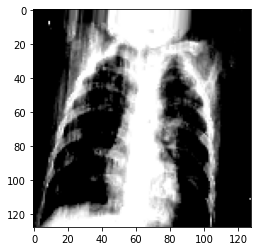

In [ ]:
plt.imshow(Xbatch[4], cmap = 'gray')

##DenseNet

1/1 [==============================] - 8s 8s/step


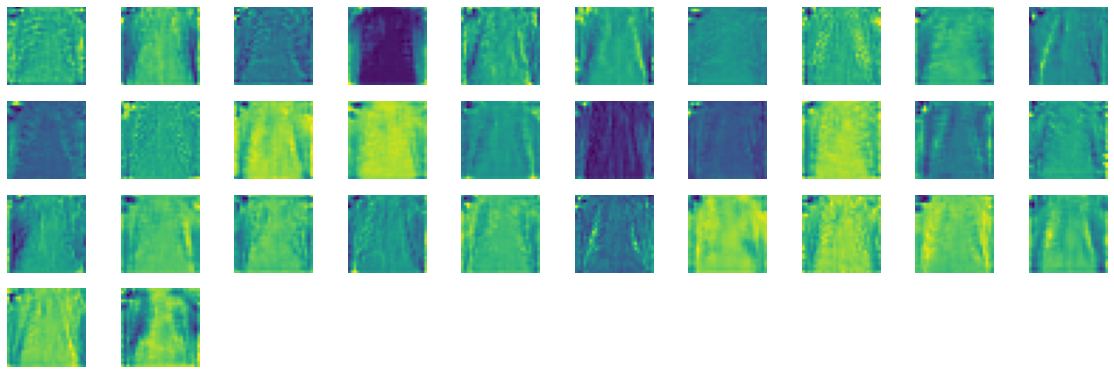

In [ ]:
# create the DenseNet121 model
model = DenseNet121(weights='imagenet', include_top=False)

# define the layer index for which you want to plot feature maps
layer_idx = 100

# create a model that outputs the feature maps for the layer of interest
layer_output = model.layers[layer_idx].output
feature_extractor = Model(inputs=model.inputs, outputs=layer_output)

# load an example image
img_path = "/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# use the feature extractor to get the feature maps for the example image
features = feature_extractor.predict(x)

# plot the feature maps
plt.figure(figsize=(20, 17))
for i in range(features.shape[-1]):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(features[0, :, :, i])


In [ ]:
densenet_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

In [ ]:
densenet_model = DenseNet121(include_top=False, weights='imagenet')
x = densenet_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x)
m_ge = Model(inputs=densenet_model.input, outputs=predictions)
METRICS = ['accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
m_ge.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=METRICS)

In [ ]:
model_ge = m_ge.fit(
    train_generator, 
    epochs=20,
    validation_data=validation_generator,
    #callbacks=[early_stopping,lr],
    verbose = 1
)

Epoch 1/20
652/652 [==============================] - 3197s 5s/step - loss: 0.1843 - accuracy: 0.9310 - precision: 0.9528 - recall: 0.9543 - val_loss: 0.3585 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/20
652/652 [==============================] - 105s 161ms/step - loss: 0.1087 - accuracy: 0.9592 - precision: 0.9722 - recall: 0.9729 - val_loss: 0.2381 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 3/20
652/652 [==============================] - 107s 165ms/step - loss: 0.0855 - accuracy: 0.9691 - precision: 0.9803 - recall: 0.9781 - val_loss: 1.4954 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/20
652/652 [==============================] - 106s 163ms/step - loss: 0.0689 - accuracy: 0.9722 - precision: 0.9814 - recall: 0.9812 - val_loss: 0.3189 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/20
652/652 [==============================] - 106s 162ms/step - loss: 0.0869 - acc

In [ ]:
m_ge.save_weights("weights/DEN_ge_weights_01")

Text(0.5, 1.0, 'Accuracy Evolution')

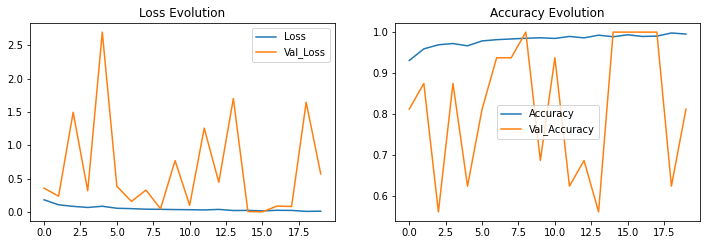

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_ge.history['loss'], label='Loss')
plt.plot(model_ge.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_ge.history['accuracy'], label='Accuracy')
plt.plot(model_ge.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = m_ge.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = m_ge.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 411s 658ms/step - loss: 2.4481 - accuracy: 0.7340 - precision: 0.7014 - recall: 1.0000
Test Accuracy: 73.40%
652/652 [==============================] - 82s 125ms/step - loss: 0.0346 - accuracy: 0.9854 - precision: 0.9808 - recall: 1.0000
Train Accuracy: 98.54%


In [ ]:
densenet_model = DenseNet121(include_top=False, weights='imagenet')
x = densenet_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x)
m_au = Model(inputs=densenet_model.input, outputs=predictions)
METRICS = ['accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
m_au.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=METRICS)

In [ ]:
model_au = m_au.fit(
    train_augmentation, 
    epochs=20,
    validation_data=validation_augmentation,
    #callbacks=[early_stopping,lr],
    verbose = 1
)

Epoch 1/20
652/652 [==============================] - 190s 197ms/step - loss: 0.2598 - accuracy: 0.8997 - precision: 0.9291 - recall: 0.9365 - val_loss: 3.5170 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
652/652 [==============================] - 126s 193ms/step - loss: 0.1561 - accuracy: 0.9390 - precision: 0.9590 - recall: 0.9590 - val_loss: 0.6052 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/20
652/652 [==============================] - 123s 189ms/step - loss: 0.1532 - accuracy: 0.9446 - precision: 0.9626 - recall: 0.9628 - val_loss: 0.3124 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/20
652/652 [==============================] - 124s 190ms/step - loss: 0.1171 - accuracy: 0.9592 - precision: 0.9729 - recall: 0.9721 - val_loss: 0.6585 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/20
652/652 [==============================] - 125s 192ms/step - loss: 0.1238 - a

In [ ]:
m_au.save_weights("weights/DEN_au_weights_01")

Text(0.5, 1.0, 'Accuracy Evolution')

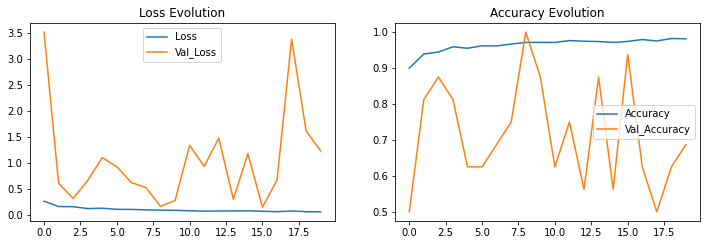

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_au.history['loss'], label='Loss')
plt.plot(model_au.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_au.history['accuracy'], label='Accuracy')
plt.plot(model_au.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = m_au.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = m_au.evaluate(train_augmentation)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 28s 46ms/step - loss: 2.7336 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%
652/652 [==============================] - 104s 160ms/step - loss: 0.1172 - accuracy: 0.9557 - precision: 0.9463 - recall: 0.9969
Train Accuracy: 95.57%


In [ ]:
pred = m_ge.predict(test_generator)
densenet_pred_classes = np.round(pred)

print(confusion_matrix(test_generator.classes, densenet_pred_classes))
pd.DataFrame(classification_report(test_generator.classes, densenet_pred_classes, output_dict=True, target_names=test_generator.class_indices.keys()))

624/624 [==============================] - 24s 35ms/step
[[ 23 211]
 [ 45 345]]


,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.338235,0.620504,0.589744,0.479369,0.514653
recall,0.098291,0.884615,0.589744,0.491453,0.589744
f1-score,0.152318,0.729387,0.589744,0.440852,0.512986
support,234.000000,390.000000,0.589744,624.000000,624.000000


In [ ]:
pred = m_ge.predict(train_generator)
densenet_pred_classes = np.round(pred)

print(confusion_matrix(train_generator.classes, densenet_pred_classes))
pd.DataFrame(classification_report(train_generator.classes, densenet_pred_classes, output_dict=True, target_names=train_generator.class_indices.keys()))

652/652 [==============================] - 80s 123ms/step
[[ 343  998]
 [ 922 2953]]


,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.271146,0.747406,0.631902,0.509276,0.624962
recall,0.255779,0.762065,0.631902,0.508922,0.631902
f1-score,0.263239,0.754664,0.631902,0.508951,0.628322
support,1341.000000,3875.000000,0.631902,5216.000000,5216.000000


In [ ]:
pred = m_au.predict(train_augmentation)
densenet_pred_classes = np.round(pred)

print(confusion_matrix(train_augmentation.classes, densenet_pred_classes))
pd.DataFrame(classification_report(train_augmentation.classes, densenet_pred_classes, output_dict=True, target_names=train_augmentation.class_indices.keys()))

652/652 [==============================] - 105s 157ms/step
[[ 293 1048]
 [ 837 3038]]


,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.259292,0.743514,0.638612,0.501403,0.619024
recall,0.218494,0.784000,0.638612,0.501247,0.638612
f1-score,0.237151,0.763221,0.638612,0.500186,0.627972
support,1341.000000,3875.000000,0.638612,5216.000000,5216.000000


In [ ]:
pred = m_au.predict(test_generator)
densenet_pred_classes = np.round(pred)

print(confusion_matrix(test_generator.classes, densenet_pred_classes))
pd.DataFrame(classification_report(test_generator.classes, densenet_pred_classes, output_dict=True, target_names=test_generator.class_indices.keys()))

624/624 [==============================] - 20s 32ms/step
[[  0 234]
 [  0 390]]


,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.0,0.625000,0.625,0.312500,0.390625
recall,0.0,1.000000,0.625,0.500000,0.625000
f1-score,0.0,0.769231,0.625,0.384615,0.480769
support,234.0,390.000000,0.625,624.000000,624.000000


##VGG-16

35363/35363 [==============================] - 0s 0us/step


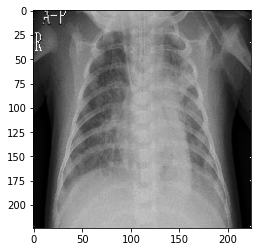

In [ ]:
vggmodel = applications.VGG16(include_top=True,weights='imagenet')
image = load_img(imgdir + "/val/PNEUMONIA/person1946_bacteria_4874.jpeg", target_size=(224,224))
plt.imshow(image)
image_toarray = img_to_array(image)
imageVGG16 = preprocess_input(image_toarray)
imageVGG16 = imageVGG16.reshape(1, 224, 224, 3)
pred = decode_predictions(vggmodel.predict(imageVGG16))

In [ ]:
pred

[[('n03450230', 'gown', 0.25042218),
  ('n03877472', 'pajama', 0.16271646),
  ('n04209239', 'shower_curtain', 0.04432016),
  ('n04350905', 'suit', 0.03615413),
  ('n03534580', 'hoopskirt', 0.027880387)]]

In [ ]:
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                  
		os.makedirs(path)          
		print("---  new folder...  ---")
	else:
		print("---  There is this folder!  ---")

In [ ]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet', 
                    input_shape=(img_size, img_size, 3))

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_vgg16_features(dataset,batch_size):
  generator = vgg_data_gen.flow_from_directory(
        imgdir + '/' + dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )
  cnn_features = feature_extractor.predict(generator)
  with open('VGG_16_' + dataset, 'wb') as f:
    np.save(f, cnn_features)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
for layer in vggmodel.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
# retrieve weights from the second hidden layer
filters , bias = vggmodel.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

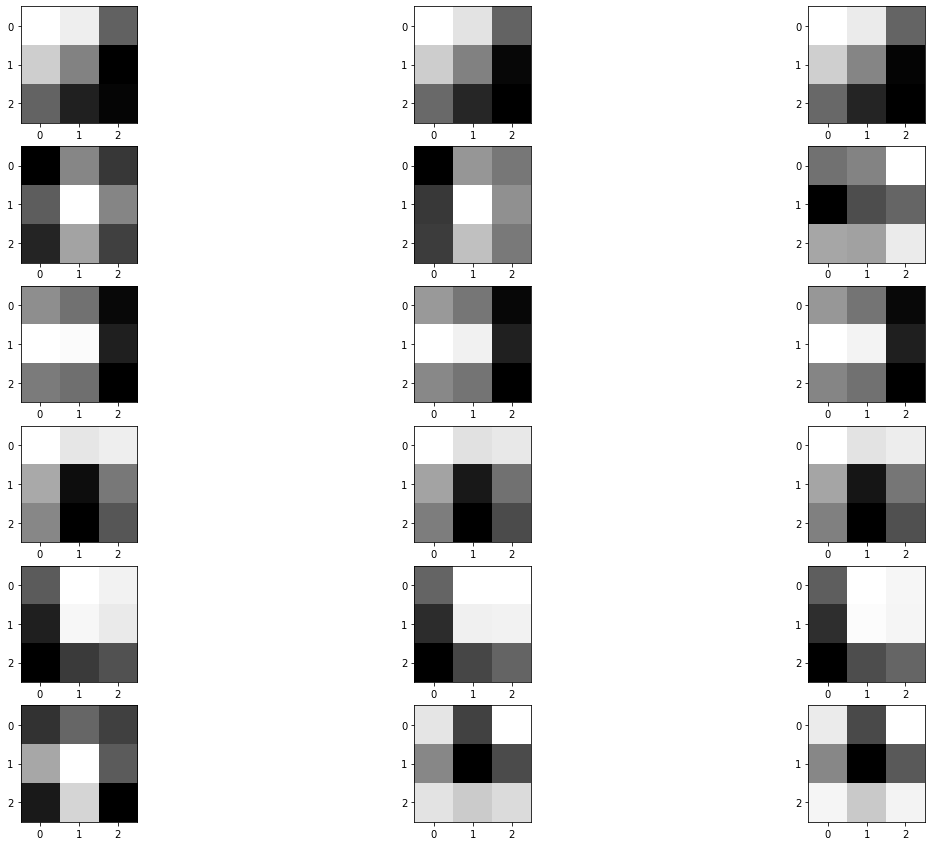

In [ ]:
from matplotlib import pyplot
n_filters =6
ix=1
fig = pyplot.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
pyplot.show()

In [ ]:
vggmodel1 = Model(inputs=vggmodel.inputs , outputs=vggmodel.layers[1].output)

image = load_img("/content/drive/MyDrive/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
image = preprocess_input(image)

1/1 [==============================] - 0s 79ms/step


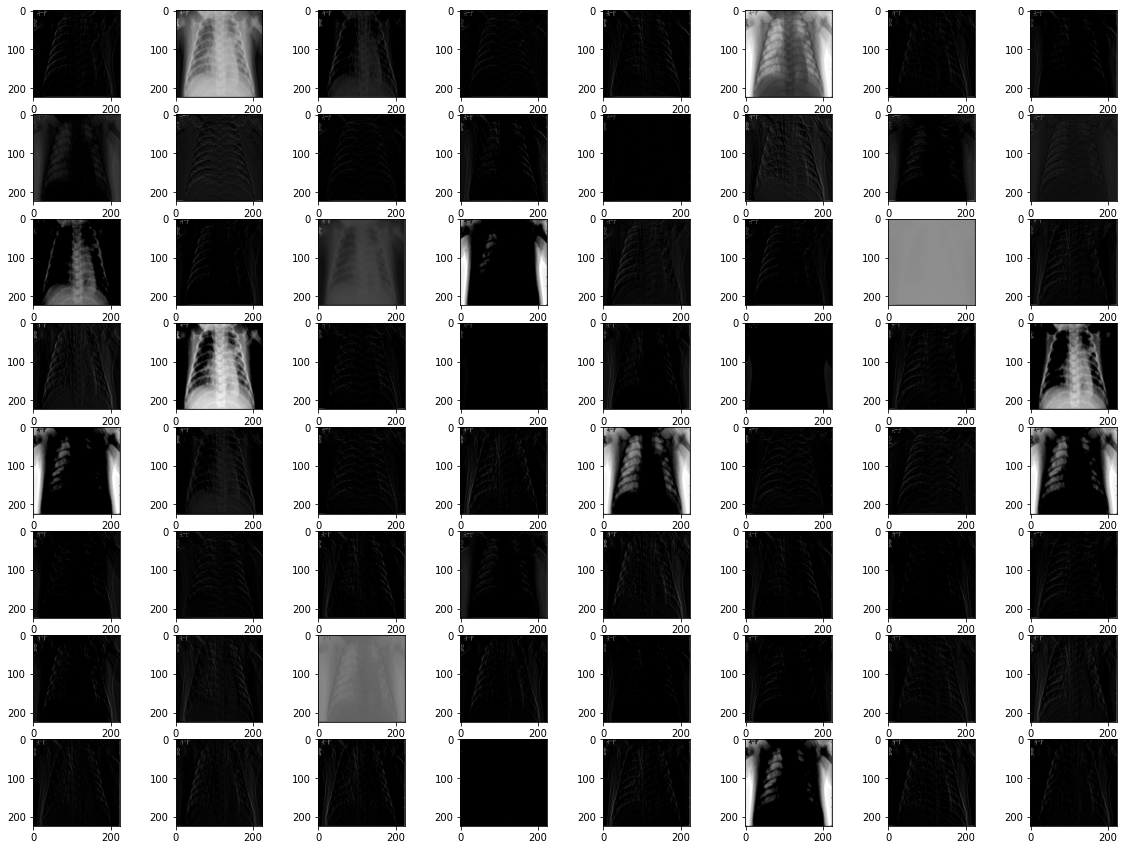

In [ ]:
#calculating features_map
features = vggmodel1.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

1/1 [==============================] - 0s 306ms/step


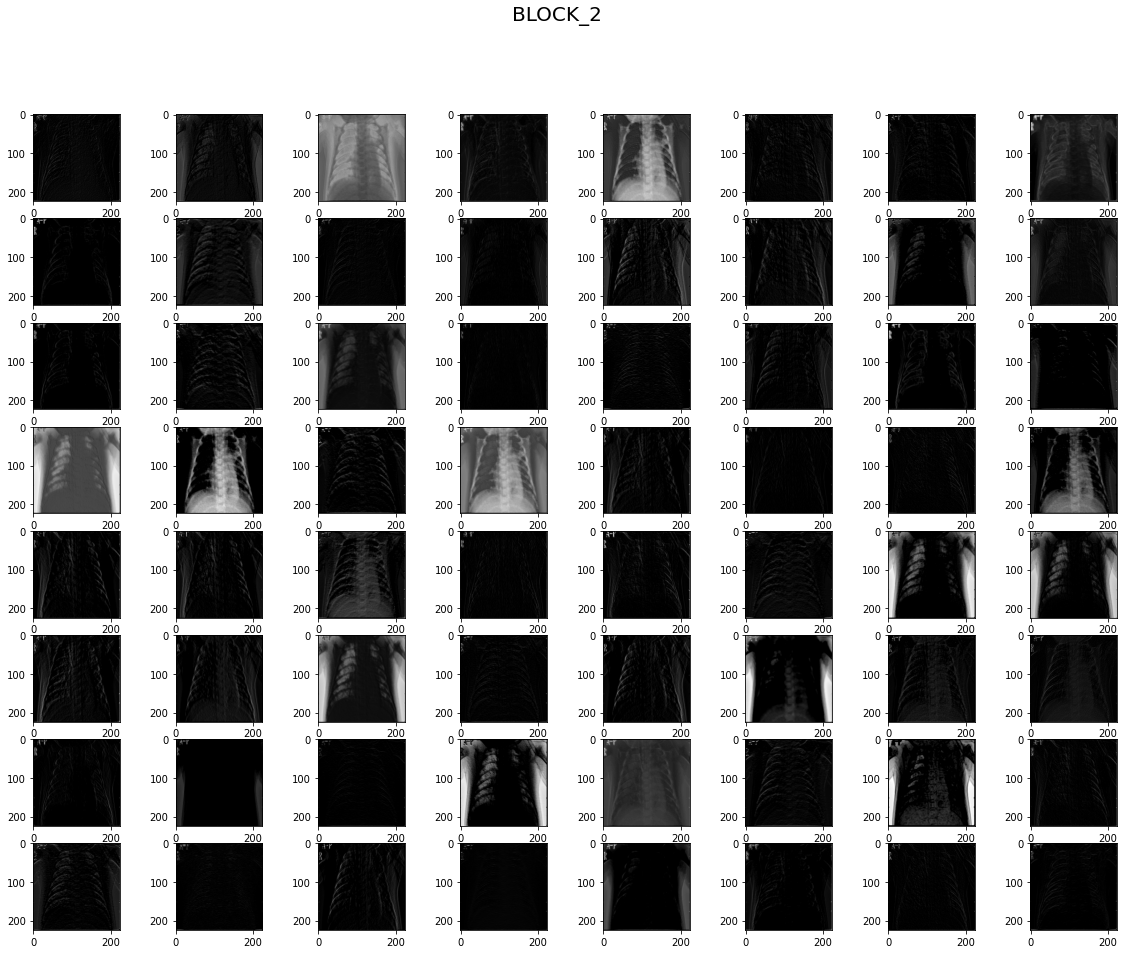

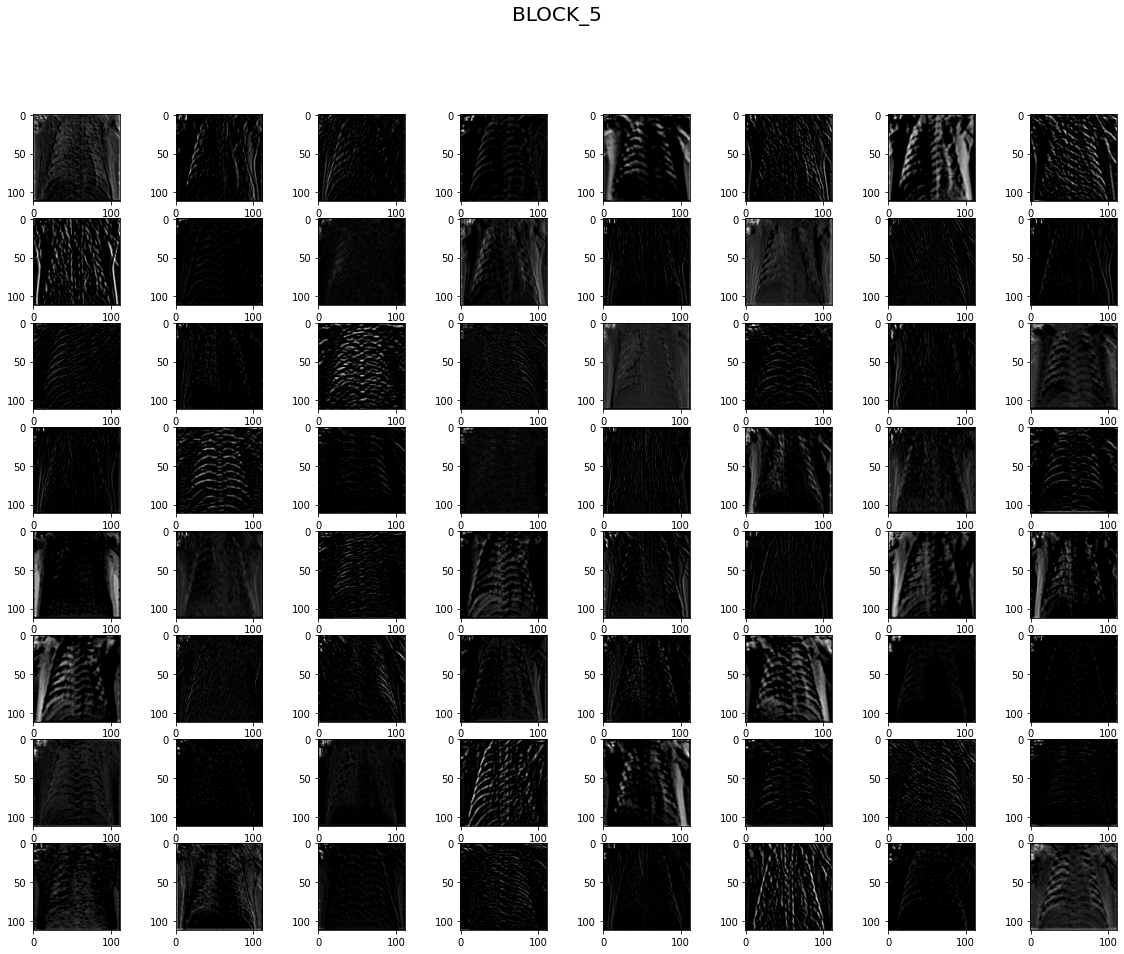

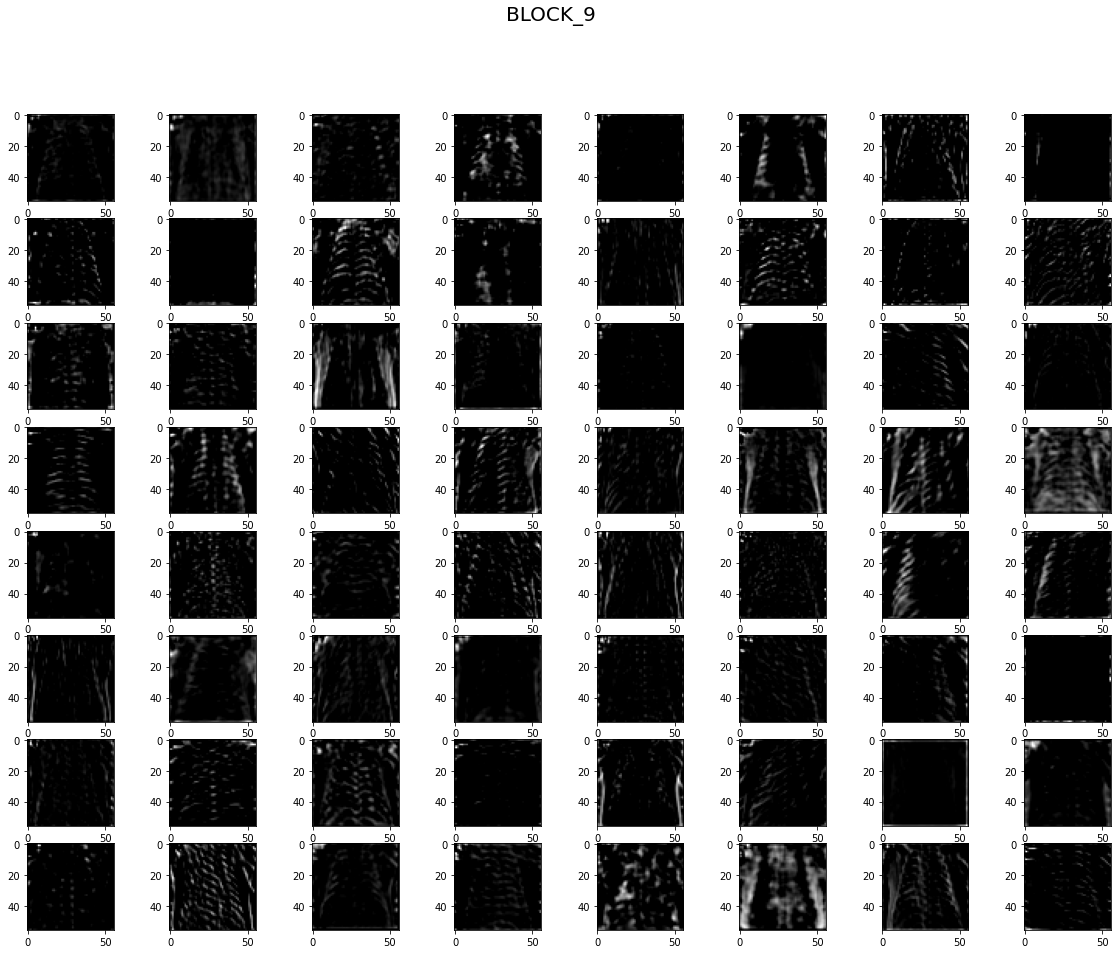

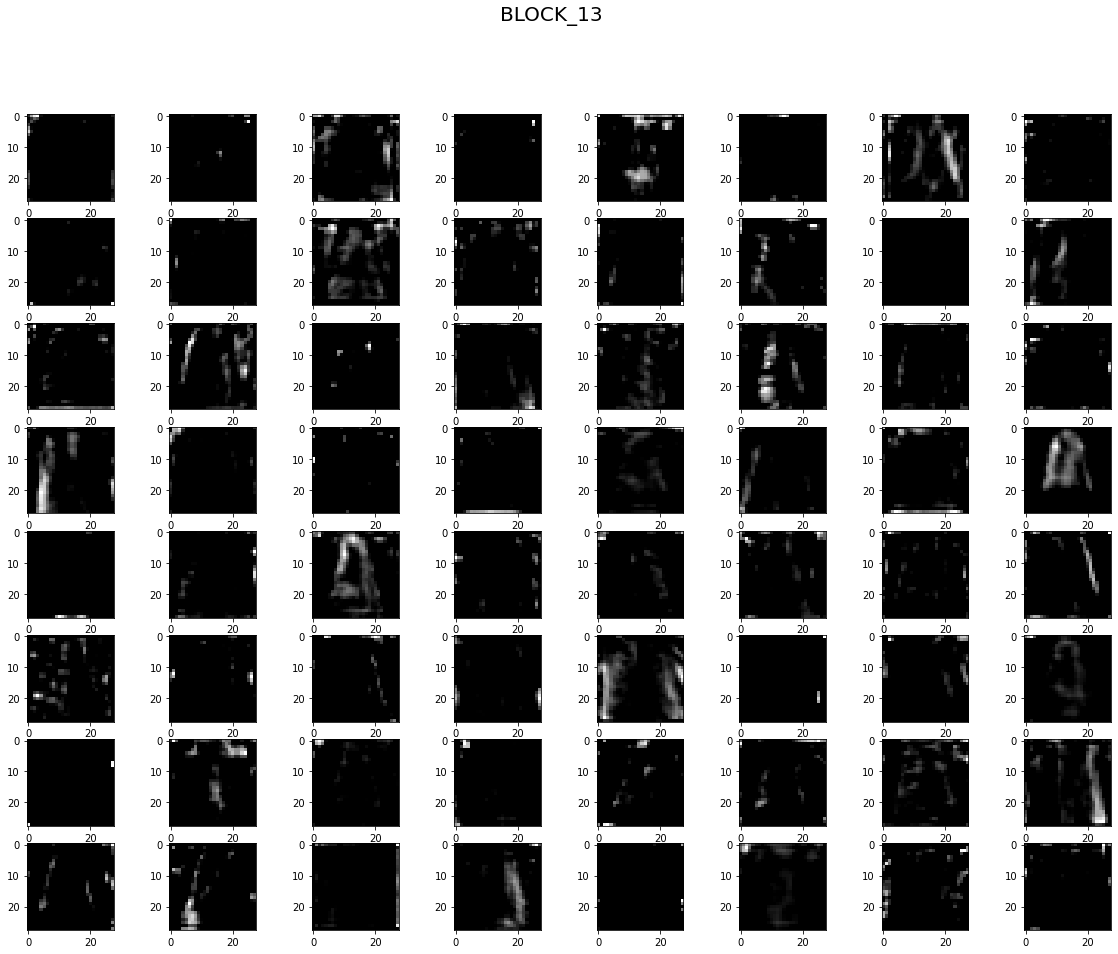

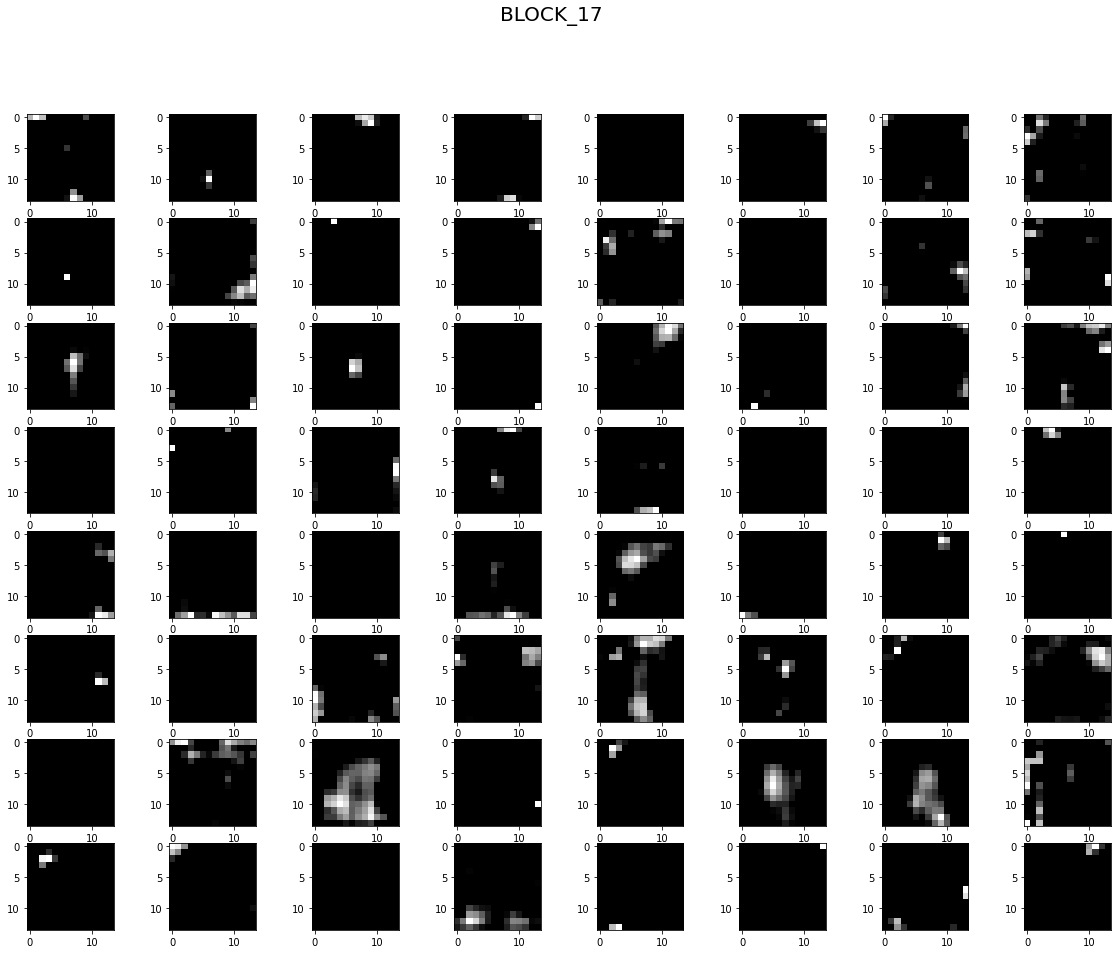

In [ ]:
blocks = [ 2, 5 , 9 , 13 , 17]
outputs = [vggmodel.layers[i].output for i in blocks]

vggmodel2 = Model( inputs= vggmodel.inputs, outputs = outputs)
feature_map = vggmodel2.predict(image)

for i,fmap in zip(blocks,feature_map):
    fig = pyplot.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        pyplot.subplot(8,8,i)
        pyplot.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

In [ ]:
create_vgg16_features("train",8)
create_vgg16_features("val",2)
create_vgg16_features("test",1)

Found 5216 images belonging to 2 classes.


652/652 [==============================] - 75s 113ms/step
Found 16 images belonging to 2 classes.
8/8 [==============================] - 1s 31ms/step
Found 624 images belonging to 2 classes.
624/624 [==============================] - 9s 13ms/step


In [ ]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

def train_on_cnnfeatures():
  with open('VGG_16_train', 'rb') as f:
    train_data = np.load(f)
  with open('VGG_16_val', 'rb') as f:
    validation_data = np.load(f)

  model = Sequential()
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
  model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=METRICS)
  
  epoch = 20
  model_fit = model.fit(train_data, get_labels(train_data.shape[0]),
              #batch_size = batch_size,
              epochs = epoch,
              verbose = 1,
              validation_data=(validation_data, get_labels(validation_data.shape[0])))
  return model, model_fit

In [ ]:
vggcnn, history = train_on_cnnfeatures()

Epoch 1/20
163/163 [==============================] - 3s 8ms/step - loss: 1.3825 - accuracy: 0.7281 - precision: 0.6906 - recall: 0.8267 - val_loss: 0.4623 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.8020 - precision: 0.7522 - recall: 0.9007 - val_loss: 0.4021 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 0.3713 - accuracy: 0.8275 - precision: 0.7830 - recall: 0.9061 - val_loss: 0.4176 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 0.3285 - accuracy: 0.8484 - precision: 0.8117 - recall: 0.9072 - val_loss: 0.3960 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 0.2908 - accuracy: 0.8654 - pr

In [ ]:
vggcnn.save_weights("weights/vggcnn_weights_01")

In [ ]:
with open('VGG_16_train', 'rb') as f:
  train_data = np.load(f)
with open('VGG_16_test', 'rb') as f:
  test_data = np.load(f)

history_test = vggcnn.fit(train_data, get_labels(train_data.shape[0]),
              #batch_size = batch_size,
              epochs = 20,
              verbose = 1,
              validation_data=(test_data, get_labels(test_data.shape[0])))

Epoch 1/20
163/163 [==============================] - 1s 4ms/step - loss: 0.1263 - accuracy: 0.9498 - precision: 0.9596 - recall: 0.9390 - val_loss: 2.6363 - val_accuracy: 0.5978 - val_precision: 0.5764 - val_recall: 0.7372
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 0.1273 - accuracy: 0.9561 - precision: 0.9591 - recall: 0.9528 - val_loss: 2.3600 - val_accuracy: 0.6170 - val_precision: 0.5915 - val_recall: 0.7564
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0629 - accuracy: 0.9808 - precision: 0.9831 - recall: 0.9785 - val_loss: 2.3710 - val_accuracy: 0.6138 - val_precision: 0.6156 - val_recall: 0.6058
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0435 - accuracy: 0.9883 - precision: 0.9926 - recall: 0.9839 - val_loss: 2.8722 - val_accuracy: 0.5962 - val_precision: 0.5893 - val_recall: 0.6346
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0360 - accuracy: 0.9893 - pr

In [ ]:
pred = vggcnn.predict(train_data)

print(confusion_matrix(train_augmentation.classes, pred > 0.5))
pd.DataFrame(classification_report(train_augmentation.classes, pred > 0.5, output_dict=True))

163/163 [==============================] - 1s 3ms/step
[[1341    0]
 [1292 2583]]


,0,1,accuracy,macro avg,weighted avg
precision,0.509305,1.000000,0.752301,0.754652,0.873845
recall,1.000000,0.666581,0.752301,0.833290,0.752301
f1-score,0.674887,0.799938,0.752301,0.737412,0.767788
support,1341.000000,3875.000000,0.752301,5216.000000,5216.000000


In [ ]:
pred = vggcnn.predict(test_data)

print(confusion_matrix(test_generator.classes, pred > 0.5))
pd.DataFrame(classification_report(test_generator.classes, pred > 0.5, output_dict=True))

20/20 [==============================] - 0s 3ms/step
[[155  79]
 [136 254]]


,0,1,accuracy,macro avg,weighted avg
precision,0.532646,0.762763,0.655449,0.647704,0.676469
recall,0.662393,0.651282,0.655449,0.656838,0.655449
f1-score,0.590476,0.702628,0.655449,0.646552,0.660571
support,234.000000,390.000000,0.655449,624.000000,624.000000


Text(0.5, 1.0, 'Accuracy Evolution')

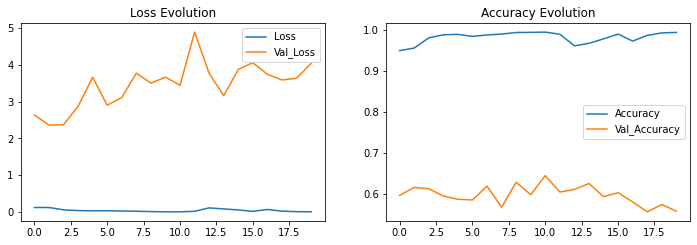

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_test.history['loss'], label='Loss')
plt.plot(history_test.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_test.history['accuracy'], label='Accuracy')
plt.plot(history_test.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

##Visualizing the learned features

In [ ]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [ ]:
def kernel_image(weights, i, positive):
    
  # extract the convolutional kernel at position i
  k = weights[:,:,:,i].copy()
  if not positive:
    k = -k
    
  # clip the values: if we're looking for positive
  # values, just keep the positive part; vice versa
  # for the negative values.
  k *= k > 0

  # rescale the colors, to make the images less dark
  m = k.max()
  if m > 1e-3:
    k /= m 

  return k

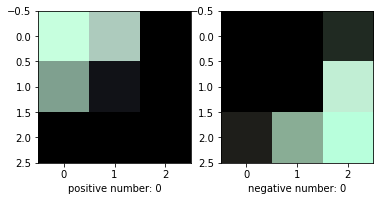

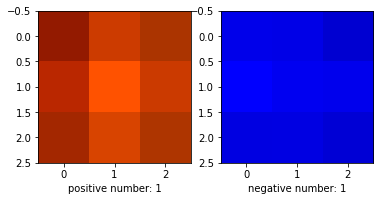

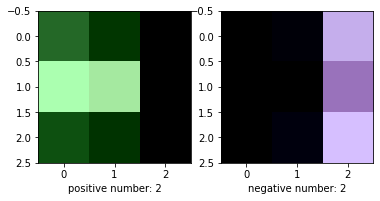

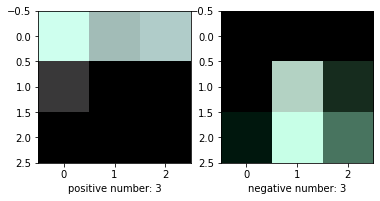

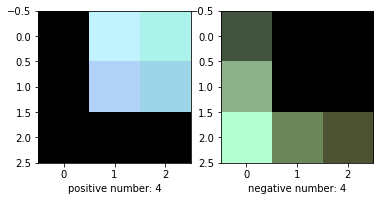

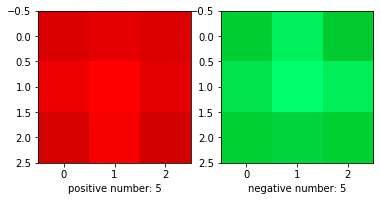

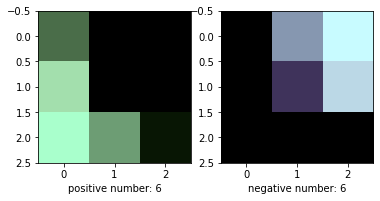

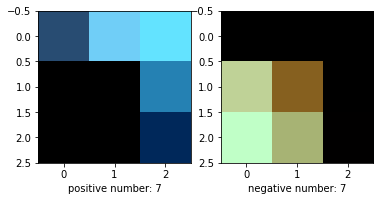

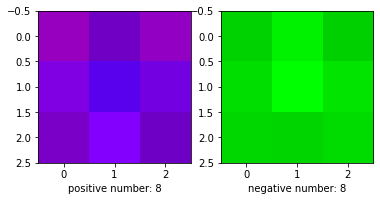

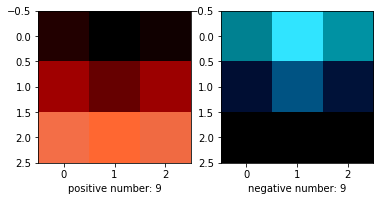

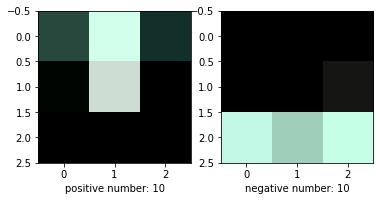

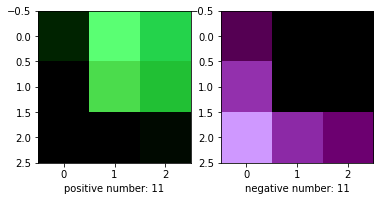

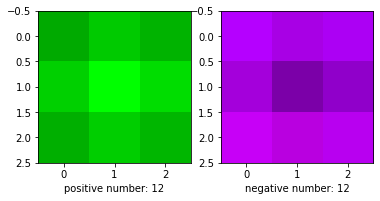

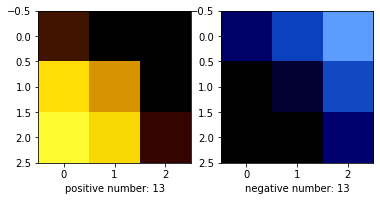

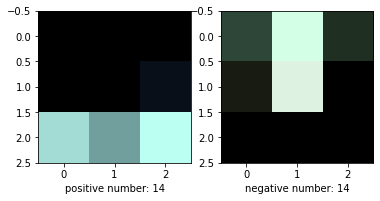

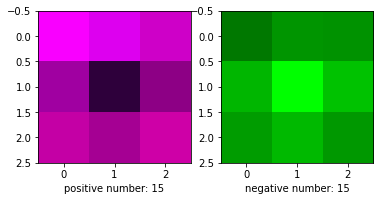

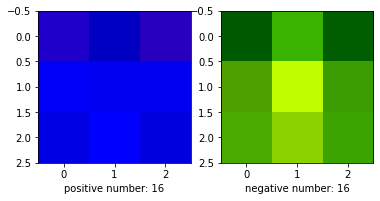

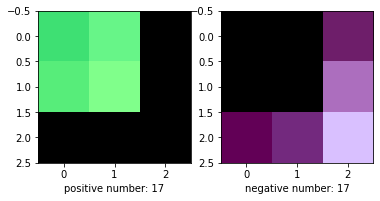

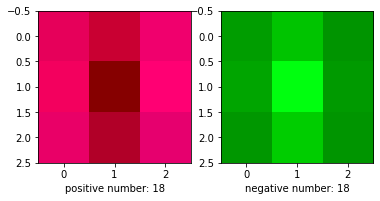

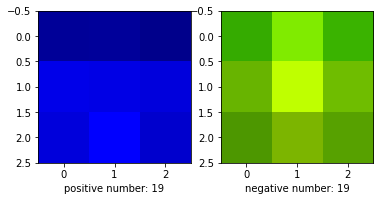

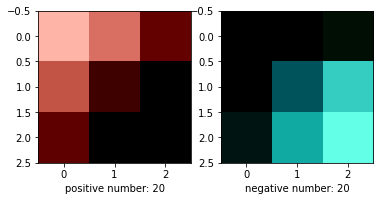

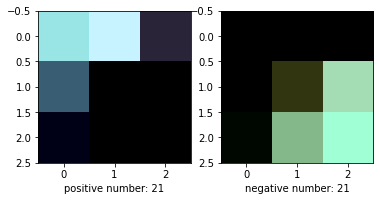

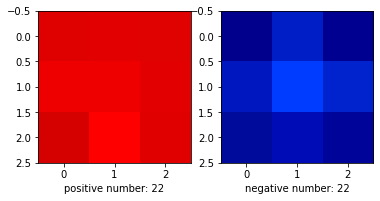

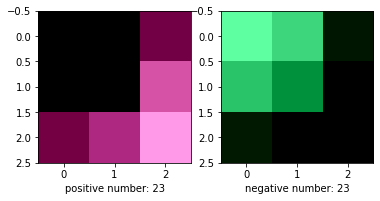

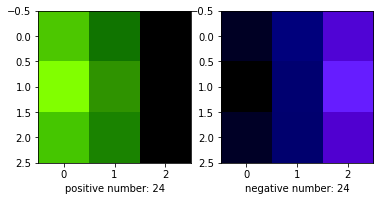

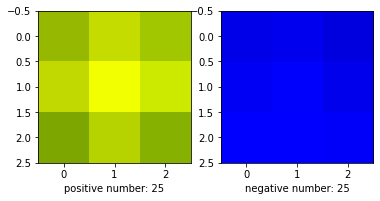

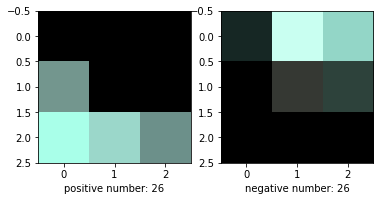

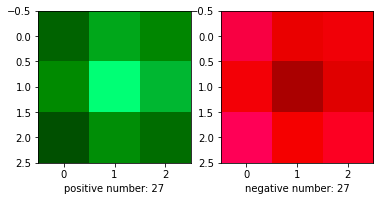

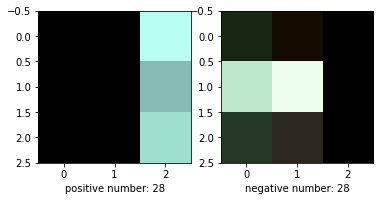

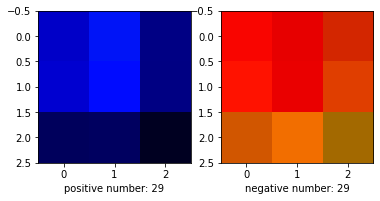

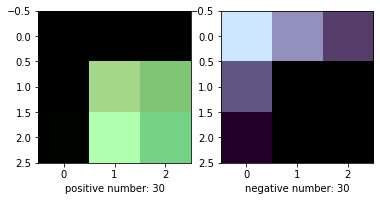

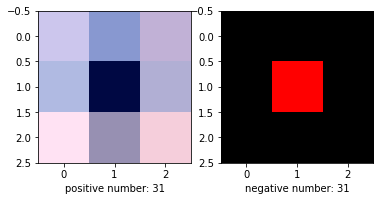

In [ ]:
for i in range(64):
  plt.subplot(1, 2, (i % 2) + 1)
  plt.imshow(kernel_image(first_layer_weights, i // 2, positive=i % 2 == 0))
  plt.xlabel(f'{"positive" if i % 2 == 0 else "negative"} number: {i // 2}')
  if i % 2 == 1:
    plt.show()

##Valuation

In [ ]:
def plot_Loss(history):
  # Plot the training and validation loss for each epoch
  plt.plot(history.epoch, history.history['loss'], color = 'red', label = 'Training')
  plt.plot(history.epoch, history.history['val_loss'], color = 'blue', label = 'Validation')
  plt.title('Model loss for each epoch')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

In [ ]:
def plot_Accuracy(history):
  # Plot the training and validation accuracies for each epoch
  plt.plot(history.epoch, history.history['accuracy'], color = 'red', label = 'Training')
  plt.plot(history.epoch, history.history['val_accuracy'], color = 'blue', label = 'Validation')
  plt.title('Model accuracy for each epoch')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

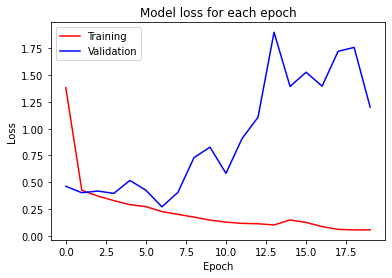

In [ ]:
plot_Loss(history)

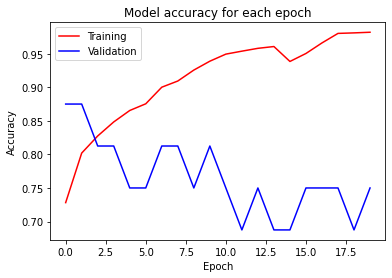

In [ ]:
plot_Accuracy(history)

624/624 [==============================] - 20s 32ms/step


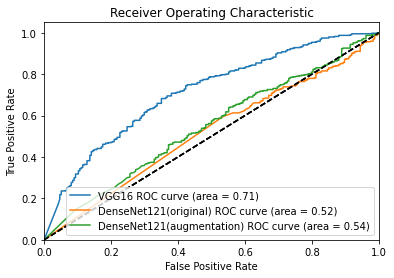

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

# Get predicted probabilities from VGG16 model
vgg16_probs = vggcnn.predict(test_data)

# Get predicted probabilities from DenseNet121 model
densenet_probs1 = m_ge.predict(test_generator)
densenet_probs2 = m_au.predict(test_generator)

# Extract true labels from test data generator
true_labels = test_generator.classes

# Plot ROC curves for both models
plot_roc_curve(true_labels, vgg16_probs, 'VGG16')
plot_roc_curve(true_labels, densenet_probs1, 'DenseNet121(original)')
plot_roc_curve(true_labels, densenet_probs2, 'DenseNet121(augmentation)')

# Show plot
plt.show()


652/652 [==============================] - 103s 158ms/step


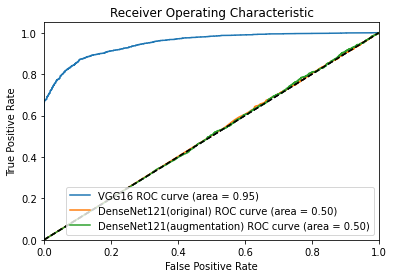

In [ ]:
# Get predicted probabilities from VGG16 model
vgg16_probs = vggcnn.predict(train_data)

# Get predicted probabilities from DenseNet121 model
densenet_probs1 = m_ge.predict(train_generator)
densenet_probs2 = m_au.predict(train_augmentation)

# Extract true labels from test data generator
true_labels = train_generator.classes
true_labels1 = train_augmentation.classes

# Plot ROC curves for both models
plot_roc_curve(true_labels, vgg16_probs, 'VGG16')
plot_roc_curve(true_labels, densenet_probs1, 'DenseNet121(original)')
plot_roc_curve(true_labels1, densenet_probs2, 'DenseNet121(augmentation)')

# Show plot
plt.show()